<a href="https://colab.research.google.com/github/azganushpoghosyan/product_data_science/blob/main/conversion_project/improve_conversion_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project overview

In our e-commerce app project, conversion rate signifies the proportion of users completing a desired action, like making a purchase, among the total app users. A critical metric in product data science, our objective is to harness user characteristics and conversion data for actionable insights. By analyzing this data, we aim to offer targeted recommendations to improve the user experience, optimize the conversion funnel, and ultimately elevate the app's overall conversion rate.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from graphviz import Source
from sklearn import tree
import pydotplus
import collections
from IPython.display import Image, display
np.random.seed(11)

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/azganushpoghosyan/product_data_science/main/conversion_project/data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


###Brief overview of columns


**Country**: The user's country determined by their IP address.

**Age**: User-reported age during the sign-up process.

**New User**: Indicates whether the user created the account during the current session (1 for new user) or already had an existing account and returned to the site (0).

**Source**: The marketing channel source through which the user reached the site:

*   *Ads*: Arrived via a click on an advertisement.
*   *SEO*: Arrived via clicking on search results.
*   *Direct*: Arrived directly by typing the URL in the browser.

**Total Pages Visited**: The count of total pages visited during the session, serving as a proxy for time spent on the site and user engagement.

**Converted**: The label for our analysis. A value of 1 indicates the user converted within the session, while 0 signifies that they left without making a purchase. The company's primary objective is to enhance the conversion rate, calculated as the number of conversions divided by the total sessions.

# Exploratory Data Analysis

Conduct initial data inspection, process as necessary for validity, and gain a preliminary understanding of the userbase through exploratory data analysis.

In [3]:
# Display summary statistics of the dataset
print(data.describe())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


In [4]:
# Group the data by 'country' and show the size of each group
print(data.groupby('country').size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [5]:
# Group the data by 'source' and show the size of each group
print(data.groupby('source').size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


Quick Observations:

* The site likely has a strong U.S. presence, but interestingly, there's also a significant user base from China.
* The majority of users seem to be on the younger side.
* The conversion rate, hovering around 3%, falls in line with industry standards - nothing unexpected.
* Everything checks out, except for a suspicious age of 123 years. Let's dig into that next.






In [6]:
# Display unique age values in descending order
print(sorted(data['age'].unique(), reverse=True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


The values of 123 and 111 appear implausible. It's essential to address them—let's assess the quantity of users affected to determine whether substitution or removal is the appropriate action.

In [7]:
# Displaying users with reported ages greater than 110 for further investigation
print(data[data['age'] > 110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


With only two users affected, we can safely remove them, as it is unlikely to impact the overall analysis. In different situations, we might opt to handle them as missing values, substitute them with averages, or employ other strategies. It's crucial to delve into the root cause of incorrect data, especially to determine if there's a systemic issue that may require an engineering solution in the future.

In [8]:
# Removing rows where reported ages are less than or equal to 110
data = data[data['age'] < 110]

Let's quickly examine the between different user characteristics across the two classes to see whether there are any meaningful insights.

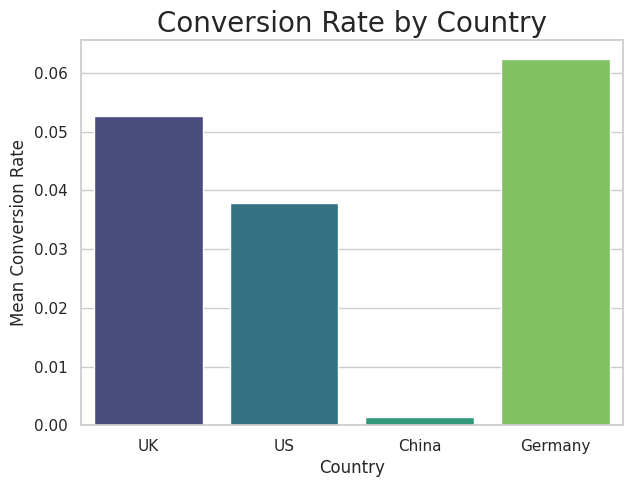

In [9]:
# Create a bar plot to visualize the mean conversion rate by country
plt.figure(figsize=(7, 5))
sns.barplot(x='country', y='converted', data=data, errorbar=None, palette='viridis')

# Add title and axis labels for clarity
plt.title('Conversion Rate by Country', fontsize = 20)
plt.xlabel('Country')
plt.ylabel('Mean Conversion Rate')

# Display
plt.show()

Despite having a substantial user base, the conversion rate for China is notably lower compared to that of other countries.

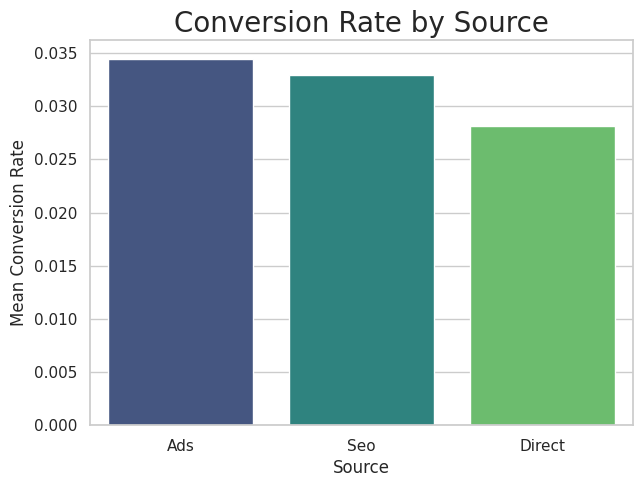

In [10]:
# Visualize the mean conversion rate by source
plt.figure(figsize=(7, 5))
sns.barplot(x='source', y='converted', data=data, errorbar=None, palette='viridis')

# Add title and axis labels for clarity
plt.title('Conversion Rate by Source', fontsize = 20)
plt.xlabel('Source')
plt.ylabel('Mean Conversion Rate')

# Display
plt.show()

The conversion rate remains relatively consistent across various sources.

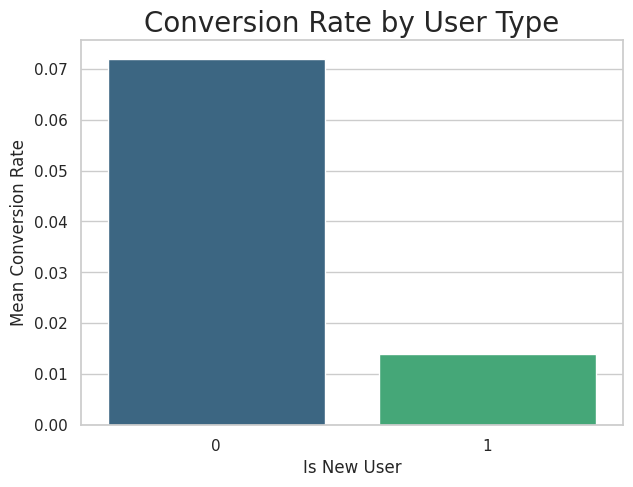

In [11]:
# Visualize the mean conversion rate by user type
plt.figure(figsize=(7, 5))
sns.barplot(x='new_user', y='converted', data=data, errorbar=None, palette='viridis')

# Add title and axis labels for clarity
plt.title('Conversion Rate by User Type', fontsize = 20)
plt.xlabel('Is New User')
plt.ylabel('Mean Conversion Rate')

# Display
plt.show()

New users are less likely to convert.

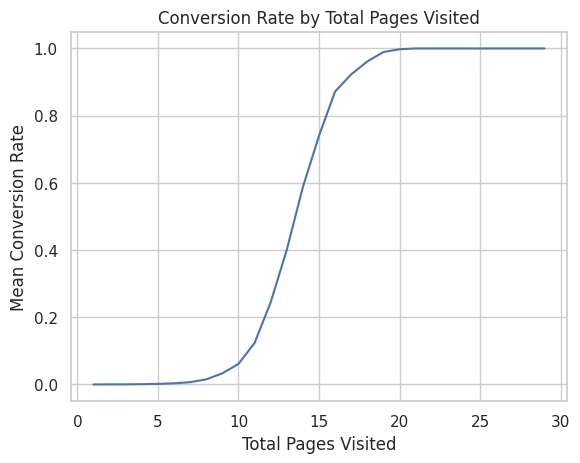

In [12]:
# Group the data by 'total_pages_visited' and plot the mean conversion rate
sns.lineplot(x='total_pages_visited', y='converted', data=data.groupby('total_pages_visited')['converted'].mean().reset_index())

# Add title and labels
plt.title('Conversion Rate by Total Pages Visited')
plt.xlabel('Total Pages Visited')
plt.ylabel('Mean Conversion Rate')

# Display the plot
plt.show()

Obviously, spending more time in the app increases the liklihood of conversion.

#Modeling

Let's proceed to construct a model for predicting conversion rates. Since the outcome is binary and we aim to extract insights for actionable project ideas some of the optimal options will be:

* Logistic Regression
* Decision Trees
* Random Forest or Boosted Decision Trees in combination with partial dependence plots

For this specific task we'll use the Random Forest model to predict conversion rates due to its simplicity in optimization and robustness with outliers. The approach involves using partial dependence plots and variable importance metrics to gain insights.

Let's begin by transforming categorical variables into dummy variables.

In [13]:
data_dummy = pd.get_dummies(data, drop_first=True)

OOB Accuracy: 0.9845078567620562


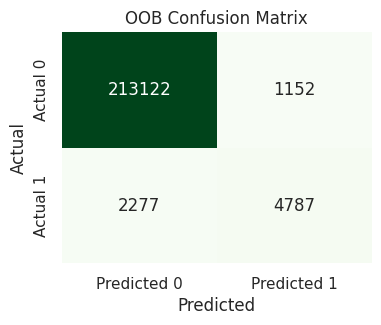

In [14]:
# Split the data into training and testing sets to prevent overfitting
train, test = train_test_split(data_dummy, test_size=0.3)

# Build the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])

# Print out-of-bag (OOB) accuracy
print("OOB Accuracy:", rf.oob_score_)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(train['converted'], rf.oob_decision_function_[:, 1].round(), labels=[0, 1])

# Plot the confusion matrix as a heatmap
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Greens', cbar = False,
            xticklabels = ['Predicted 0', 'Predicted 1'], yticklabels = ['Actual 0', 'Actual 1'])

plt.title('OOB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

Test Accuracy: 0.9838393421884883


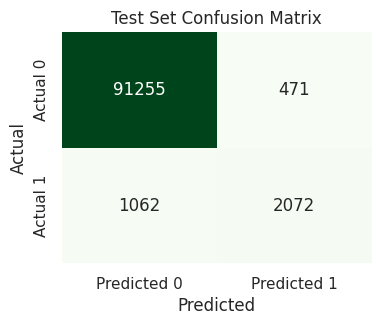

In [15]:
# Evaluate the model on the test set and print accuracy along with the confusion matrix
test_accuracy = rf.score(test.drop('converted', axis=1), test['converted'])
test_predictions = rf.predict(test.drop('converted', axis=1))

print("Test Accuracy:", test_accuracy)

# Calculate Confusion Matrix
conf_matrix_test = confusion_matrix(test['converted'], test_predictions, labels=[0, 1])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

The OOB error and test error closely align, suggesting minimal overfitting. Let's now explore variable importance.







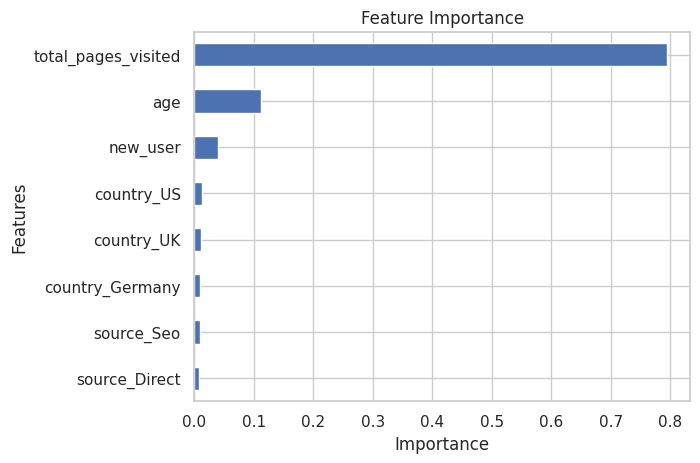

In [16]:
# Calculate and visualize feature importances
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)

feat_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

Looking at our data, the most important factor is how many pages a user visits. However, we can't really control or influence that - people naturally browse more when they're interested in buying. So, let's try building our model again without considering this feature and make some adjustments to ensure it predicts purchases effectively, given the uneven distribution of classes.

OOB Accuracy: 0.8957883418120702


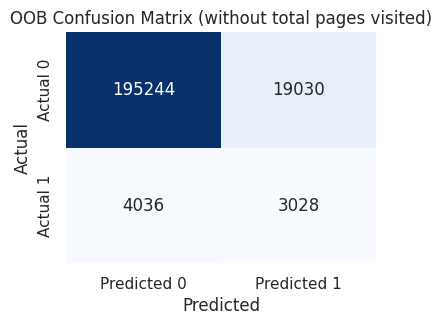

In [17]:
# Build the Random Forest model without considering 'total_pages_visited'
rf_no_pages = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0: 1, 1: 10})
rf_no_pages.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

# Print out-of-bag (OOB) accuracy
print("OOB Accuracy:", rf_no_pages.oob_score_)

# Calculate confusion matrix
conf_matrix_no_pages = confusion_matrix(train['converted'], rf_no_pages.oob_decision_function_[:, 1].round(), labels=[0, 1])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_no_pages, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

plt.title('OOB Confusion Matrix (without total pages visited)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

OOB Accuracy: 0.8974645112904246


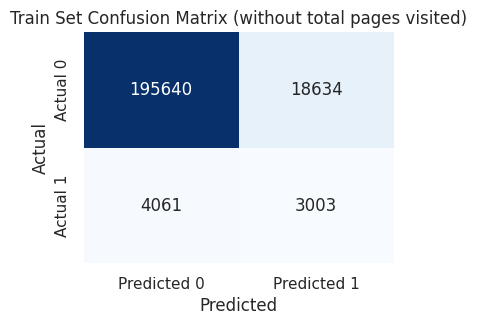

In [18]:
# Build the Random Forest model without considering 'total_pages_visited'
rf_no_pages = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0: 1, 1: 10})
rf_no_pages.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

# Print out-of-bag (OOB) accuracy
print("OOB Accuracy:", rf_no_pages.oob_score_)

# Calculate confusion matrix
conf_matrix_no_pages = confusion_matrix(train['converted'], rf_no_pages.oob_decision_function_[:, 1].round(), labels=[0, 1])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_no_pages, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

plt.title('Train Set Confusion Matrix (without total pages visited)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

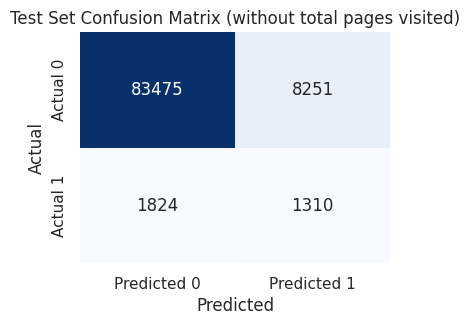

In [19]:
# Evaluate the model on the test set and print accuracy along with the confusion matrix
test_accuracy_no_pages = rf_no_pages.score(test.drop(['converted', 'total_pages_visited'], axis=1), test['converted'])
test_predictions_no_pages = rf_no_pages.predict(test.drop(['converted', 'total_pages_visited'], axis=1))

# Calculate the confusion matrix
conf_matrix_test_no_pages = confusion_matrix(test['converted'], test_predictions_no_pages, labels=[0, 1])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_test_no_pages, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

plt.title('Test Set Confusion Matrix (without total pages visited)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

Recheck variable importance

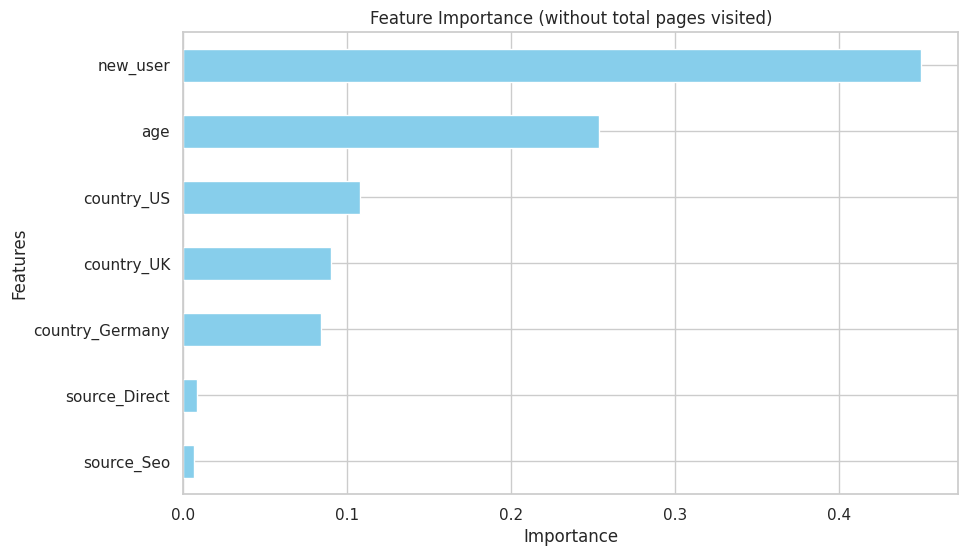

In [20]:
# Calculate feature importances for the model without considering 'total_pages_visited'
feat_importances_no_pages = pd.Series(rf_no_pages.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)

# Plot feature importances
plt.figure(figsize=(10, 6))
feat_importances_no_pages.sort_values().plot(kind='barh', color='skyblue')

plt.title('Feature Importance (without total pages visited)')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

The model places significant importance on new user status and age, whereas the dummy variables related to the data source seem to have less impact.

Let's check partial dependence plots.
Partial dependence plots illustrate the relationship between a specific feature and the predicted outcome in a machine learning model, holding other variables constant. They provide insights into how individual features influence predictions, facilitating the interpretation and understanding of a model's behavior.

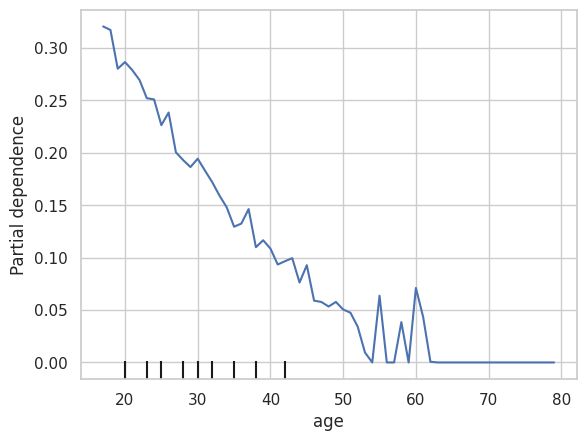

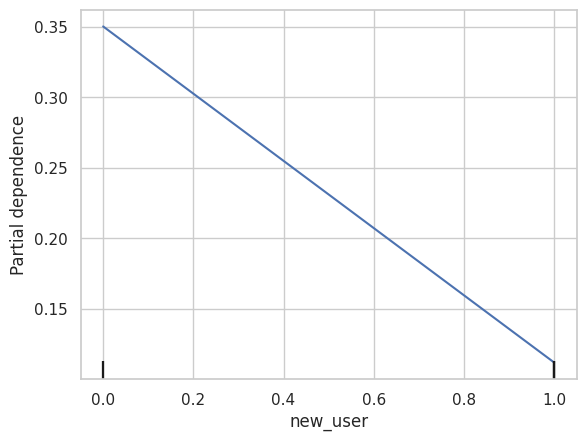

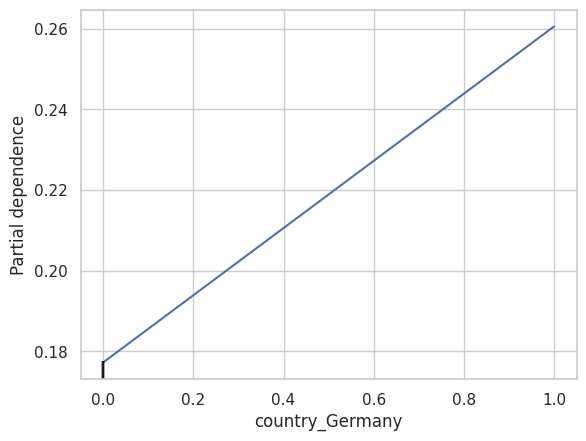

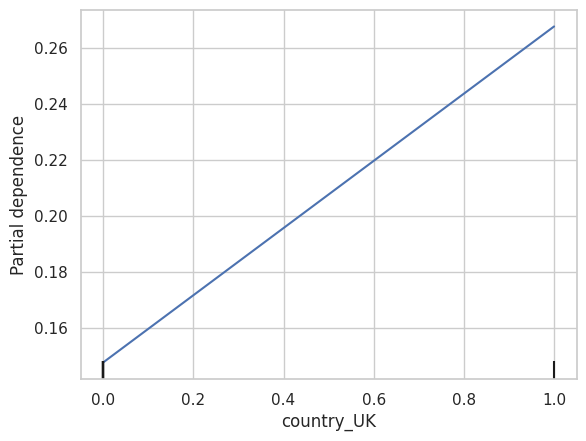

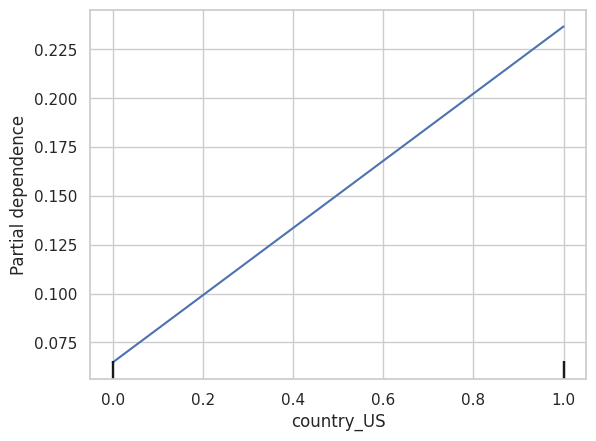

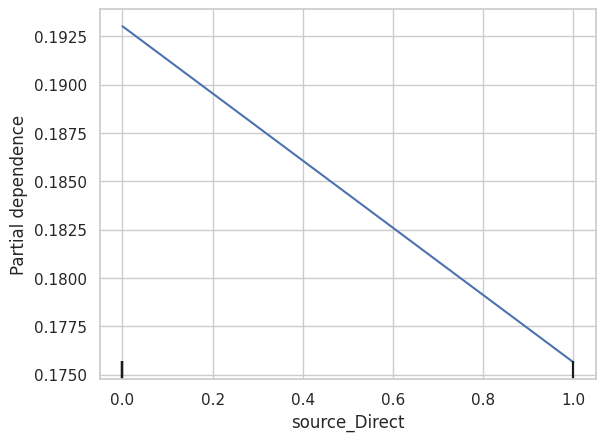

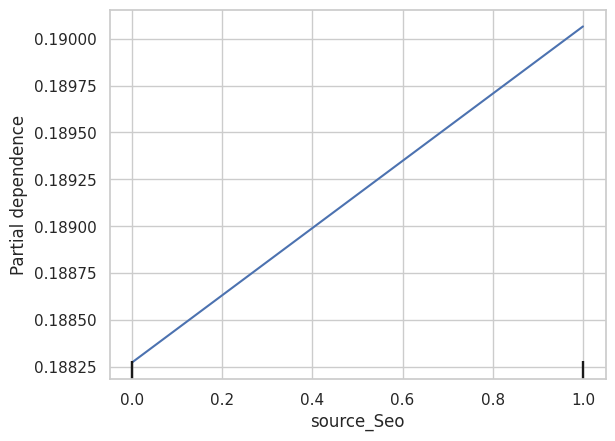

In [21]:
# Visualize partial dependence plots for each feature
for i in range(len(feat_importances_no_pages)):
    display = PartialDependenceDisplay.from_estimator(rf_no_pages, train.drop(['converted', 'total_pages_visited'], axis=1), [i, ])
    plt.show()

We see that:
- New users convert less than the old ones.
- Germany, the UK, and the US show high values, suggesting a considerable boost in conversion probability compared to China, which has a lower likelihood of conversion.
- The source doesn't have a strong influence on conversion.

# Summary and Next Actions:

* The site demonstrates strong performance among young users; recommend targeted marketing efforts to reach this demographic more effectively.

* Germany shows high conversion rates but has a lower user count compared to the UK; suggest an increase in marketing efforts to attract more German users.

* Users with older accounts exhibit better performance; propose implementing targeted email campaigns to re-engage this user segment.

* Investigate the user interface for older users, as the conversion rate drops significantly around the age of 30; consider forming a team to improve the experience for users aged 30 and above.

* Identify issues with the Chinese version of the site, whether related to translation, cultural fit, or payment problems; prioritize fixing these issues due to the significant user base in China.